In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.style.use('ggplot')
from numpy.linalg import svd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

C:\Users\mtsia\AppData\Local\Temp\ipykernel_8392\1157823357.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
#TRAIN DATA
X_train = pd.read_excel('data.xlsx', sheet_name = 'azip', header=None).T # training images (each image is 16x16)
y_train = pd.read_excel('data.xlsx', sheet_name = 'dzip', header=None).T # vector that holds the digits (the number)

#TEST DATA
X_test = pd.read_excel('data.xlsx', sheet_name = 'testzip', header=None).T
y_test = pd.read_excel('data.xlsx', sheet_name = 'dtest', header=None).T

print(f'Shape of X_train: {X_train.shape}, y_train: {y_train.shape}\nShape of X_test: {X_test.shape}, y_test: {y_test.shape}')
#Each row is an image, each column is a feature (indicator of one of the 256 pixels of the 16x16 image)

Shape of X_train: (1707, 256), y_train: (1707, 1)
Shape of X_test: (2007, 256), y_test: (2007, 1)


In [4]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,-0.167,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,-1.000,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.996,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,-0.067,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,0.234,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0


In [5]:
y_train.head()

,0
0,6
1,5
2,4
3,7
4,3


In [6]:
def ima2(A: np.array, colormap: str='binary') -> None:
    '''
    Translate vector to become nonnegative 
    Scale to interval [0,20], https://stackoverflow.com/questions/50305206/how-to-normalize-array-between-1-and-10
    Reshape the vector as a matrix and then show image 
    '''
    if isinstance(A, pd.Series):
        A = A.values #A is a column of X_train -- a digit
    #A = (256*A).astype(np.uint8)
    A = A.reshape(16,16)
    A = (A - A.min())/(A.max() - A.min()) * 20
    
    #colormap = [1.0000, 1.0000, 1.0000, 0.8715, 0.9028, 0.9028, 0.7431, 0.8056, 0.8056, 0.6146, 0.7083, 0.7083, 0.4861, 0.6111, 0.6111, 0.3889, 0.4722, 0.5139, 0.2917, 0.3333, 0.4167, 0.1944, 0.1944, 0.3194, 0.0972, 0.0972, 0.1806, 0, 0, 0.0417]
    #colors = ListedColormap(colormap)
    plt.axis('off')
    plt.imshow(A, cmap=colormap) 

In [7]:
#Training: For the training set of known digits, compute the SVD of each set of digits of one kind.
def svd_computation(X, y):
    
    #Empty lists for left,right singular and singular matrix
    u = []
    s = []
    v_t = []

    for i in range(len(y.iloc[:,0].unique())): #0-9
    
        #Create new DataFrame for each digit
        digit = X[y.iloc[:,0] == i].T
    
        u.append(svd(digit, full_matrices=False)[0])
        s.append(svd(digit, full_matrices=False)[1]) #singular matrix
        v_t.append(svd(digit, full_matrices=False)[2])

    return u, s, v_t #returns 3 lists, each contains 10 matrixes. to index: [grab u,s or v_t][grab digit]

In [8]:
u_k = svd_computation(X_train, y_train)[0]

In [9]:
#Classification: For a given test digit, compute its relative residual in all bases. If one residual is significantly smaller than all the others, classify as that. Otherwise give up.
def classification(X, y, basis):
    
    I = np.eye(X.shape[1])
    predictions = []
    
    for image in range(X.shape[0]): #X.shape[0] -- 2007 images
        #iterate through all images 
        errors = []
        
        for j in range(len(y.iloc[:,0].unique())):
            z = X.iloc[image,:]
            #iterate through u vectors of each digits and calculate 10 errors
            #U_k = svd_computation(X_train, y_train)[0][j][:,:k] #keep first k lines of u
            error = np.linalg.norm((I - u_k[j][:,:basis].dot(u_k[j][:,:basis].T)).dot(z), 2)
            errors.append(error)
            
        predictions.append(np.argmin(errors))
            
    return np.asarray(predictions)

In [10]:
predictions = classification(X_test, y_test, 20) 

### SPECIFIC TASKS

##### (1)  Tune the algorithm for accuracy of classification. Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.

In [11]:
tuning = pd.DataFrame({'Basis': np.arange(5,21)})
accuracy = []

for basis in range(5,21):
    predictions = classification(X_test, y_test, basis)
    accuracy.append(accuracy_score(predictions, y_test))
    
tuning['Accuracy'] = np.asarray(accuracy)

In [12]:
tuning

,Basis,Accuracy
0,5,0.902840
1,6,0.905331
2,7,0.916791
3,8,0.920279
4,9,0.926258
5,10,0.931739
6,11,0.932237
7,12,0.935725
8,13,0.936223
9,14,0.939213


In [13]:
tuning.Basis[tuning.Accuracy == max(tuning.Accuracy)].values[0]

18

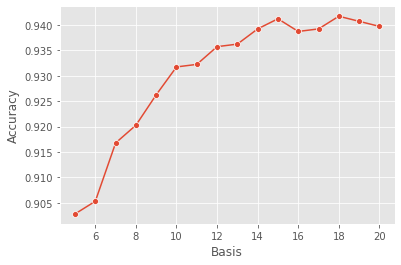

In [14]:
sns.lineplot(x="Basis", y="Accuracy", data=tuning, marker="o");

##### (2) Check if all digits are equally easy or difficult to classify. Also look at some of the difficult ones, and see that in many cases they are very badly written.

In [15]:
ideal_basis = tuning.Basis[tuning.Accuracy == max(tuning.Accuracy)].values[0]
predictions = classification(X_test, y_test, ideal_basis)
conf_matrix = confusion_matrix(y_test, predictions)

<AxesSubplot:>

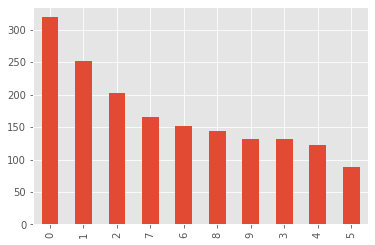

In [16]:
#check if dataset is balanced
y_train.iloc[:,0].value_counts().plot.bar()

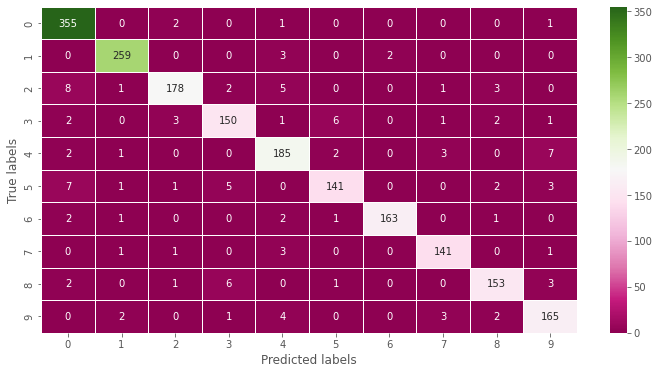

In [33]:
plt.figure(figsize=(12,6))
ax= plt.subplot()
sns.heatmap(conf_matrix, linewidths=1, annot=True, fmt='g', cmap="PiYG");
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [18]:
report = pd.DataFrame(classification_report(y_test.iloc[:,0],predictions, output_dict=True)).T
report[:10]['f1-score'].sort_values()

5    0.906752
3    0.909091
4    0.915842
9    0.921788
2    0.927083
8    0.930091
7    0.952703
0    0.963365
6    0.973134
1    0.977358
Name: f1-score, dtype: float64

As we see, the digits that are the least accuratrly classified based on the f1-score are 5 and 3:

In [19]:
combined = pd.DataFrame({'y_test': y_test.iloc[:,0].values, 'predictions': predictions})

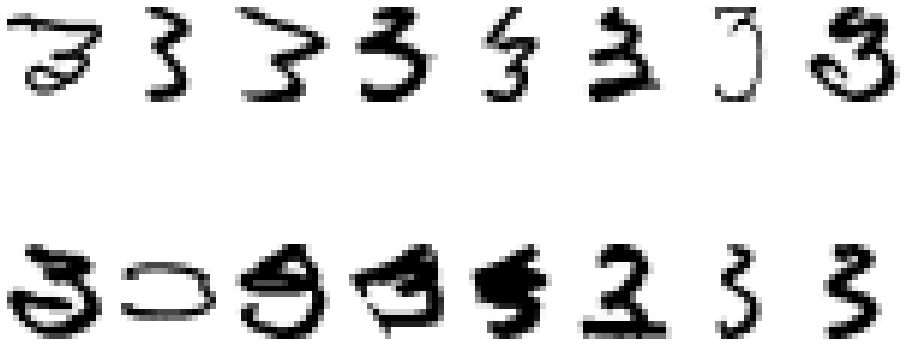

In [20]:
#Missclassified digit: 3
wrong_3 = combined[combined.y_test == 3][combined.y_test != combined.predictions]

plt.figure(figsize=(16,8))
count = 0
for i in wrong_3.index:
    plt.subplot(2, 8, count +1)
    count +=1
    ima2(X_test.iloc[i, :])

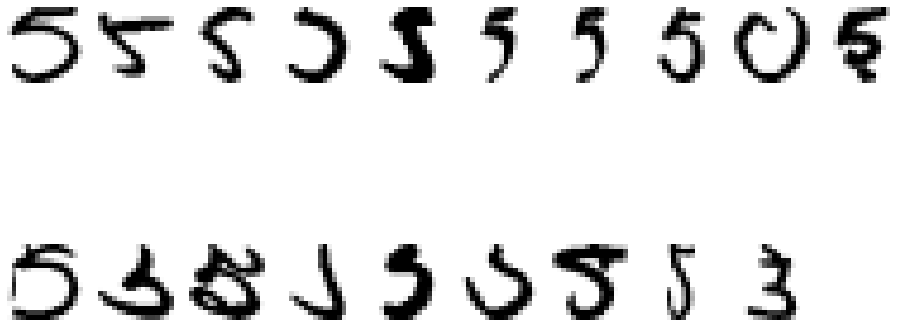

In [21]:
#Missclassified digit: 5
wrong_5 = combined[combined.y_test == 5][combined.y_test != combined.predictions]

plt.figure(figsize=(16,8))
count = 0
for i in wrong_5.index:
    plt.subplot(2, 10, count + 1)
    count +=1
    ima2(X_test.iloc[i, :])

##### (3) Check the singular values of the different classes. Is it motivated to use different numbers of basis vectors for different classes? If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes.

As we saw above, the optimal value of basis vectors is k=18. This number is optimal for all classes combined, not taking into account the classification of each digit seperately. The question that arises is whether a different value for k for each class-digit would work better in classifying a new digit. The singular values matrix contains 100% of the information of the initial matrix X_train. If we use the first 18 singular vector, how much % of total infromation do we get for each digit?

In [22]:
#all singular values, of all digits (singular values that are on the main diagonal of Σ, not the matrix Σ)
singular_values = pd.DataFrame(svd_computation(X_train, y_train)[1]) 
singular_values.iloc[:,:18]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,184.447498,97.593884,62.050613,54.149312,41.060201,40.368471,36.282942,30.023087,29.001073,24.949545,23.142277,20.029451,19.870917,19.046537,18.360257,17.835228,17.526940,16.693415
1,234.041517,41.930906,24.849243,16.294807,13.610955,12.521781,11.228837,10.668493,8.413382,8.321270,8.040238,7.486697,6.909096,6.213995,6.004267,5.498721,5.275816,4.902657
2,138.283700,57.397394,46.395696,40.960031,37.505307,33.531600,32.237997,28.406120,27.120125,26.734988,24.898081,23.419079,22.442951,21.438898,20.677361,19.333201,18.644012,18.286461
3,126.638236,39.773673,33.322457,29.873724,27.964630,24.767813,24.390306,21.460863,19.059788,18.595081,18.010639,16.341309,15.599663,14.783076,14.243716,13.907169,12.807251,11.920285
4,123.027065,41.626024,34.934312,32.290758,26.811828,24.565546,21.867543,20.449292,20.081728,18.455546,16.761867,15.662295,14.771968,14.278478,13.716672,13.218108,12.922055,12.476587
5,94.284126,37.852991,35.774941,28.020672,24.046663,22.437847,20.631232,20.363652,17.061520,16.811561,15.611715,15.104080,14.188865,13.109270,12.369351,11.661915,11.059781,10.819781
6,141.959617,52.194661,37.965846,32.014514,26.285055,25.137240,21.200502,20.935886,19.342891,18.888835,16.460618,15.256177,14.630335,13.548804,12.927611,12.498506,11.910960,11.853664
7,160.196984,46.710359,36.525125,34.687637,31.495607,22.465547,20.348184,19.192541,17.585415,16.785083,15.250702,14.385379,13.929526,12.973956,12.238269,11.185433,10.939189,10.469037
8,133.067806,41.643537,34.459963,30.495632,28.716664,25.479007,22.615018,21.891738,20.911898,19.470118,17.731461,17.041839,16.279046,15.649010,15.013789,14.068164,13.808374,13.565801
9,141.223909,45.725127,30.058437,29.457084,22.934433,20.500314,18.805483,16.976047,15.211704,14.801217,13.884412,13.047194,12.524200,11.833524,11.759370,10.997804,10.244530,9.730679


Each row of this dataframe is a digit 0-9. The columns printed represent the first 18 basis vectors used for each class.

In [23]:
singular_values.iloc[1,:1].sum() / singular_values.iloc[1,:].sum()

0.4213737002636408

In [24]:
percentages = pd.DataFrame()

for k in range(5,21):
    per = []
    for i in range(0,10):
        #each iteration should do 9 praxeis
        per.append(100*(singular_values.iloc[i,:k].sum() / singular_values.iloc[i,:].sum()))     
    percentages[k] = per
        
percentages #rows=digits, columns = numbwer of basis vectors

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,28.591630,31.218984,33.580434,35.534465,37.421980,39.045804,40.552002,41.855605,43.148890,44.388520,45.583485,46.744278,47.885007,48.971486,50.030760,51.028542
1,59.544922,61.799373,63.821038,65.741818,67.256583,68.754763,70.202346,71.550268,72.794197,73.912979,74.994001,75.984003,76.933873,77.816559,78.675951,79.484646
2,22.384423,24.726035,26.977312,28.960997,30.854877,32.721861,34.460569,36.095994,37.663253,39.160396,40.604358,41.954454,43.256422,44.533420,45.768581,46.950889
3,27.722722,30.388498,33.013643,35.323490,37.374907,39.376308,41.314805,43.073631,44.752633,46.343745,47.876806,49.373644,50.752097,52.035085,53.299769,54.522305
4,29.176701,31.947359,34.413720,36.720121,38.985066,41.066600,42.957110,44.723603,46.389679,48.000097,49.547150,51.037972,52.495404,53.902593,55.276656,56.601317
5,29.600660,32.619920,35.396081,38.136235,40.432051,42.694233,44.794962,46.827382,48.736651,50.500648,52.165081,53.734321,55.222537,56.678458,58.079138,59.407732
6,32.121478,34.901749,37.246602,39.562187,41.701582,43.790756,45.611360,47.298749,48.916917,50.415465,51.845306,53.227686,54.545082,55.856140,57.105390,58.282896
7,35.221342,37.776984,40.091757,42.275067,44.275553,46.184995,47.919888,49.556344,51.140943,52.616837,54.009041,55.281476,56.525899,57.716839,58.815740,59.885055
8,27.142490,29.719263,32.006392,34.220373,36.335260,38.304335,40.097574,41.821070,43.467422,45.050056,46.568448,47.991207,49.387691,50.759644,52.077855,53.322075
9,35.987591,38.726120,41.238246,43.505986,45.538038,47.515254,49.370000,51.112906,52.785947,54.366726,55.937598,57.406736,58.775249,60.075119,61.326497,62.562469


(0.0, 3.0)

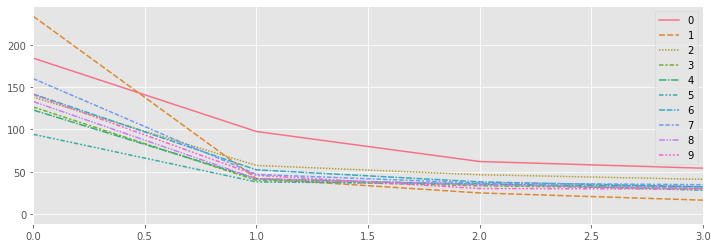

In [32]:
plt.figure(figsize=(12,4))
sns.lineplot(data=singular_values.T)
plt.xlim(0,3)

It looks like only the digit 1 uses a big percentage of the information given in order to be classified. Additionally, as seen from the plot above, it seems like most of the information about each digit is gathered in the first 10 basis vectors. Then, all singular vectors seem to have equally small values. I will try using fewer basis vectors in the classes that provide a lot of information for k=18 basis vectors: these are digit 1(79.48%) and digit 9(62.56%).

In [26]:
#Classification: For a given test digit, compute its relative residual in all 10 bases. If one residual is significantly smaller than all the others, classify as that. Otherwise give up.
def alternative_classification(X, y, basis):
    
    I = np.eye(X.shape[1])
    predictions = []
    
    for image in range(X.shape[0]): #X.shape[0] -- 2007 images
        #iterate through all images 
        errors = []
        
        for j in range(len(y.iloc[:,0].unique())):
            z = X.iloc[image,:]
            if j == 1:
                error = np.linalg.norm((I - u_k[j][:,:5].dot(u_k[j][:,:5].T)).dot(z), 2)
                errors.append(error)
            elif j == 9:
                error = np.linalg.norm((I - u_k[j][:,:5].dot(u_k[j][:,:5].T)).dot(z), 2)
                errors.append(error)
            else:
                error = np.linalg.norm((I - u_k[j][:,:basis].dot(u_k[j][:,:basis].T)).dot(z), 2)
                errors.append(error)
            
        predictions.append(np.argmin(errors))
            
    return np.asarray(predictions)

In [27]:
predictions = alternative_classification(X_test, y_test, ideal_basis)
accuracy_score(predictions, y_test)

0.9172894867962132

The accuracy of this classification process is worse than the initial one. As a result, we can't assume that this method pays off.

#### TWO-STAGE ALGORITHM WITH SVD

In order to save operations in the test phase, implement a two-stage algorithm: In the first stage compare the unknown digit only to the first singular vector in each class. If for one class the residual is significantly smaller than for the others, classify as that class. Otherwise perform the algorithm above. Is it possible to get as good results for this variant? How frequently is the second stage unnecessary?

In [28]:
#Classification: For a given test digit, compute its relative residual in all 10 bases. If one residual is significantly smaller than all the others, classify as that. Otherwise give up.
def two_stage_classification(X, y, basis):
    
    I = np.eye(X.shape[1])
    count_1 = 0
    count_2 = 0
    predictions = []
    
    for image in range(X.shape[0]): #X.shape[0] -- 2007 images
        #iterate through all images
        errors_1 = []
        errors_2 = []
        errors = []
        for j in range(len(y.iloc[:,0].unique())): #go through all classes
            z = X.iloc[image,:] #grab image
            error_1 = np.linalg.norm((I - u_k[j][:,:1].dot(u_k[j][:,:1].T)).dot(z), 2)
            error_2 = np.linalg.norm((I - u_k[j][:,:basis].dot(u_k[j][:,:basis].T)).dot(z), 2)
            errors_1.append(error_1)
            errors_2.append(error_2) 
         
        if np.sort(errors_1)[0] < np.sort(errors_1)[1] - 3: #at least 3 difference
            predictions.append(np.argmin(errors_1))
            count_1 += 1

        else:
            #iterate through u vectors of each digits and calculate 10 errors
            predictions.append(np.argmin(errors_2))
            count_2 += 1
        
    print(f"Total number of predictions: {y.shape[0]}.\nOnly the first singular vector was used for {count_1} predictions, whereas {basis} singular vectors were used for {count_2} predictions.")
    return np.asarray(predictions)

In [29]:
predictions = two_stage_classification(X_test, y_test, ideal_basis)
accuracy_score(predictions, y_test)

Total number of predictions: 2007.
Only the first singular vector was used for 460 predictions, whereas 18 singular vectors were used for 1547 predictions.


0.9417040358744395